In [2]:
# Car Sales Forecasting Comparison
# Models: ARIMA, RandomForest, LSTM
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# ========== Load Data ==========
from google.colab import files
#uploaded = files.upload()  # Upload LTOTALNSA.csv
df = pd.read_csv("LTOTALNSA.csv")

df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE').sort_index()
series = df['LTOTALNSA']
df.head()

,LTOTALNSA
DATE,
1976-01-01,864.6
1976-02-01,973.3
1976-03-01,1216.1
1976-04-01,1163.2
1976-05-01,1176.1


In [5]:
# Train-test split (80/20)
n = len(series)
train_size = int(n * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

In [6]:
# ========== 1. ARIMA ==========
arima_order = (5,1,2)   # simple example, could tune with auto_arima
model_arima = ARIMA(train, order=arima_order)
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))

arima_rmse = np.sqrt(mean_squared_error(test, forecast_arima))
arima_mae = mean_absolute_error(test, forecast_arima)
arima_mape = np.mean(np.abs((test - forecast_arima) / test)) * 100

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

In [7]:
# ========== 2. Random Forest Regressor ==========
def create_lag_features(series, lags=12):
    df_lag = pd.DataFrame({'y': series})
    for lag in range(1, lags+1):
        df_lag[f'lag_{lag}'] = df_lag['y'].shift(lag)
    return df_lag.dropna()

lags = 12
df_lag = create_lag_features(series, lags=lags)
train_lag, test_lag = df_lag.iloc[:train_size], df_lag.iloc[train_size:]

X_train_rf, y_train_rf = train_lag.drop('y', axis=1), train_lag['y']
X_test_rf, y_test_rf = test_lag.drop('y', axis=1), test_lag['y']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_rf, y_train_rf)
forecast_rf = rf.predict(X_test_rf)

rf_rmse = np.sqrt(mean_squared_error(y_test_rf, forecast_rf))
rf_mae = mean_absolute_error(y_test_rf, forecast_rf)
rf_mape = np.mean(np.abs((y_test_rf - forecast_rf) / y_test_rf)) * 100

In [8]:
# ========== 3. LSTM ==========
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(series.values.reshape(-1,1))

def create_sequences(data, window=24):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled, window=window_size)
train_size_seq = int(len(X) * 0.8)
X_train, X_test = X[:train_size_seq], X[train_size_seq:]
y_train, y_test = y[:train_size_seq], y[train_size_seq:]

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size,1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=16,
          validation_split=0.1, verbose=1, callbacks=[es])

forecast_lstm = model.predict(X_test)
forecast_lstm = scaler.inverse_transform(forecast_lstm)
y_test_rescaled = scaler.inverse_transform(y_test)

lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, forecast_lstm))
lstm_mae = mean_absolute_error(y_test_rescaled, forecast_lstm)
lstm_mape = np.mean(np.abs((y_test_rescaled - forecast_lstm) / y_test_rescaled)) * 100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1194 - val_loss: 0.0165
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0271 - val_loss: 0.0133
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0196 - val_loss: 0.0132
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0216 - val_loss: 0.0134
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0229 - val_loss: 0.0130
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0220 - val_loss: 0.0139
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0198 - val_loss: 0.0130
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0208 - val_loss: 0.0134
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0205 - val_loss: 0.0148
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0224 - val_loss: 0.0132
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0226 - val_loss: 0.0127
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

In [9]:
# ========== Results ==========
results = pd.DataFrame({
    "Model": ["ARIMA", "RandomForest", "LSTM"],
    "RMSE": [arima_rmse, rf_rmse, lstm_rmse],
    "MAE": [arima_mae, rf_mae, lstm_mae],
    "MAPE (%)": [arima_mape, rf_mape, lstm_mape]
})

print("\n=== Forecasting Results ===")
print(results)


=== Forecasting Results ===
          Model        RMSE         MAE   MAPE (%)
0         ARIMA  239.627757  204.953111  14.681055
1  RandomForest  140.735998   95.149432   7.490139
2          LSTM  180.013890  134.829235  10.648405


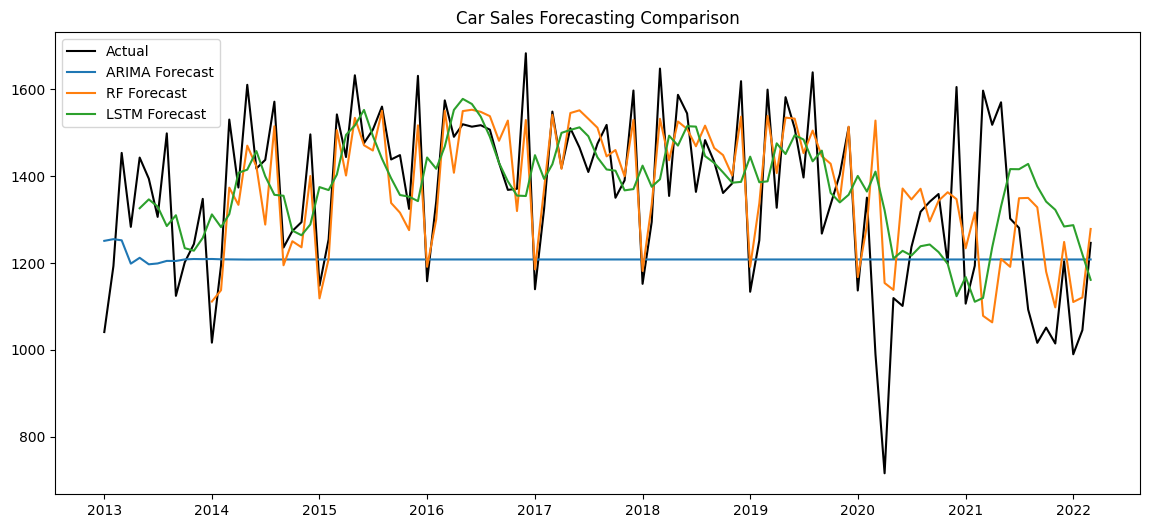

In [10]:
# ========== Visualization ==========
plt.figure(figsize=(14,6))
plt.plot(test.index, test.values, label="Actual", color="black")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast")
plt.plot(test_lag.index, forecast_rf, label="RF Forecast")
plt.plot(test.index[-len(forecast_lstm):], forecast_lstm.flatten(), label="LSTM Forecast")
plt.legend()
plt.title("Car Sales Forecasting Comparison")
plt.show()